In [1]:
import datetime
import polars as pl # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from upsetplot import UpSet, from_contents
from matplotlib.patches import Patch

In [2]:
rice_idmapping_file_path = "../out/rice_down/rice_down_idmapping.tsv"
foldseek_result_file_path = "../out/rice_down/foldseek_output_uniprot_down_all_evalue01.tsv"
main_target_species = 9606
output_tsv_path = "../out/rice_down/foldseek_rice_down_9606.tsv"

In [3]:
VERSION = datetime.datetime.now().strftime("%Y%m%d")

print(f"Execute Date: {VERSION}")

Execute Date: 20241029


In [4]:
rice_idmapping = pl.read_csv(
    rice_idmapping_file_path,
    separator='\t'
)

display(rice_idmapping)

From,UniProt Accession
str,str
"""Os01g0105300""","""A0A0P0UWX1"""
"""Os01g0136300""","""A0A8J8YJH9"""
"""Os01g0136300""","""Q5ZC68"""
"""Os01g0137950""","""A0A0P0UXR3"""
"""Os01g0179600""","""B7FAP2"""
…,…
"""Os12g0610800""","""A0A0N7KUC5"""
"""Os12g0630100""","""Q0ILR1"""
"""Os12g0630100""","""Q2QLS8"""


In [5]:
foldseek_result_all = pl.read_csv(
    foldseek_result_file_path,
    separator='\t'
).with_columns(
    (pl.col("query").str.extract(r"AF-(.*?)-F1", 1).alias("query")), # "?" means non-greedy
    (pl.col("target").str.extract(r"AF-(.*?)-F1", 1).alias("target"))
).rename(
    {
        "query" : "UniProt Accession",
        "target" : "foldseek hit"
    }
)

foldseek_result_all_v2 = rice_idmapping.join(   
    foldseek_result_all,
    on="UniProt Accession",
    how="left",
    coalesce=True,
    validate="1:m"
)

foldseek_result_all_hit = foldseek_result_all_v2.filter(
    pl.col("foldseek hit").is_not_null()
)

display(foldseek_result_all_hit)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0136300""","""Q5ZC68""","""A0A0E0MR30""",2.8540e-18,1.0,0,99.3,0.993,155,1,156,156,1,156,156,156,1.0,1.0,0.7216,0.1887,0.1887,0.1898,25.76,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…",1,"""1.000,1.000,1.000,1.000,1.000,…"
"""Os01g0136300""","""Q5ZC68""","""B6TY29""",0.0004153,0.981,5,44.2,0.442,69,1,156,156,1,138,138,156,1.0,1.0,0.6002,0.1905,0.2088,0.2097,30.65,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…","""MAVKLNKPPKAKSLWILVRRLL-RRSRNPP…",69,"""1.000,0.958,0.964,0.969,0.944,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A1D6MLT8""",1.2610e-26,1.0,1,75.1,0.751,154,2,204,204,312,516,517,205,0.995,0.397,0.915,0.9065,0.3643,0.9153,5.033,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHYCCNTRIVHFDIKPQNILLDHNFCPK…",49,"""0.957,0.947,0.967,0.911,0.893,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A804N087""",7.2770e-26,1.0,1,73.8,0.738,150,2,204,204,412,611,617,203,0.995,0.324,0.9086,0.9107,0.3079,0.933,3.419,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHYCCNTRIVHFDIKPQNILLDHNFCPK…",50,"""0.963,0.961,0.967,0.938,0.921,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A804QI27""",3.0170e-24,1.0,0,75.1,0.751,142,2,190,204,98,286,290,189,0.926,0.652,0.8772,0.8724,0.6207,0.9437,1.821,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHHSCNTRIVHFDIKPQNILLDQNFHPK…",47,"""0.968,0.947,0.967,0.932,0.914,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0630200""","""Q2QLS7""","""A0A804NJC1""",0.01307,0.998,9,25.6,0.256,41,1,127,238,8,149,149,160,0.534,0.953,0.4104,0.3006,0.4518,0.5226,6.14,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""MANTRVFVL--LLLAVAVA---VVYSADAA…","""LAPMMILALAAVLLATAARQPSPVMSTTTT…",68,"""0.688,0.778,0.795,0.729,0.654,…"
"""Os12g0630200""","""Q2QLS7""","""B4G0Z7""",0.01231,0.996,11,12.5,0.125,29,15,237,238,26,163,167,232,0.937,0.826,0.3719,0.3268,0.4442,0.5263,10.86,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""AVAVVYSADAATITVVNRCRYTVWPGALP-…","""DLTHDNCVKNKKVTVQNLCSHDVTLTLEPL…",100,"""0.304,0.327,0.396,0.328,0.406,…"
"""Os12g0630200""","""Q2QLS7""","""A8MR68""",0.06226,0.9,10,10.9,0.109,16,2,125,238,18,152,168,146,0.521,0.804,0.3947,0.2209,0.2925,0.3728,13.42,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""ANTRVFVLLLLAVAVAVVYS------ADAA…","""SSTFIIFTLALEFSDVTAEAPDGFLPLAKK…",97,"""0.639,0.795,0.917,0.904,0.875,…"


### すべての設定した生物種においてすべてヒットしていない遺伝子

In [6]:
no_hit = foldseek_result_all_v2.filter(
    pl.col("foldseek hit").is_null()
).select(
    ["From", "UniProt Accession"]
).with_columns(
    pl.col("From").is_in(foldseek_result_all_hit["From"]).alias("exists_in_hit")
)

all_no_hit = no_hit.filter(
    pl.col("exists_in_hit") == False
).sort(
    ["From"], descending=False
)

print(all_no_hit.group_by("From").n_unique())
display(all_no_hit)

shape: (68, 3)
┌──────────────┬───────────────────┬───────────────┐
│ From         ┆ UniProt Accession ┆ exists_in_hit │
│ ---          ┆ ---               ┆ ---           │
│ str          ┆ u32               ┆ u32           │
╞══════════════╪═══════════════════╪═══════════════╡
│ Os07g0251200 ┆ 1                 ┆ 1             │
│ Os02g0594232 ┆ 1                 ┆ 1             │
│ Os06g0294950 ┆ 2                 ┆ 1             │
│ Os10g0570200 ┆ 2                 ┆ 1             │
│ Os04g0302900 ┆ 1                 ┆ 1             │
│ …            ┆ …                 ┆ …             │
│ Os06g0574700 ┆ 4                 ┆ 1             │
│ Os11g0170900 ┆ 1                 ┆ 1             │
│ Os01g0747750 ┆ 1                 ┆ 1             │
│ Os06g0591200 ┆ 2                 ┆ 1             │
│ Os01g0525701 ┆ 1                 ┆ 1             │
└──────────────┴───────────────────┴───────────────┘


From,UniProt Accession,exists_in_hit
str,str,bool
"""Os01g0105300""","""A0A0P0UWX1""",false
"""Os01g0329075""","""A0A0P0V2D0""",false
"""Os01g0444100""","""A0A0P0V376""",false
"""Os01g0495701""","""A0A0P0V2W9""",false
"""Os01g0525701""","""A0A0P0V3I1""",false
…,…,…
"""Os12g0282000""","""Q0INX0""",false
"""Os12g0282000""","""Q2QTV2""",false
"""Os12g0571400""","""C7J9X9""",false


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Foldseek result of Human

In [7]:
foldseek_result_human = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([main_target_species])
)

display(foldseek_result_human)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0137950""","""A0A0P0UXR3""","""K7EP59""",0.001585,1.0,11,16.9,0.169,36,12,204,204,172,361,432,213,0.946,0.44,0.5168,0.4548,0.2316,0.4883,21.03,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""IIHFDIKPQNILLDQDFCPKIADFGLAKLC…","""IVHKDIKPGNLLLTTGGTLKISDLGVAEAL…",134,"""0.628,0.669,0.730,0.738,0.821,…"
"""Os01g0179600""","""B7FAP2""","""Q5DT01""",2.4880e-15,1.0,28,15.8,0.158,84,10,486,487,25,469,534,531,0.979,0.833,0.5143,0.6251,0.5752,0.6787,6.307,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ANEAHHFLVVTYPAQGHINPARHLARRLAR…","""WAESGKVLVV-PIDGSHWLSMREVLREL--…",307,"""0.544,0.475,0.523,0.579,0.642,…"
"""Os01g0179600""","""B7FAP2""","""I6VBT8""",7.8850e-16,1.0,29,14.0,0.14,76,7,486,487,21,468,533,541,0.986,0.841,0.5018,0.5958,0.5495,0.6433,7.547,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""EAVANEAHHFLVVTYPAQGHINPARHLARR…","""GPVVSHAGKILLI-PVDGSHWLS--MLGAI…",311,"""0.425,0.538,0.597,0.721,0.633,…"
"""Os01g0179600""","""B7FAP2""","""I6VBU3""",8.3290e-16,1.0,29,13.6,0.136,74,7,486,487,21,468,533,541,0.986,0.841,0.4991,0.5944,0.5481,0.6415,7.103,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""EAVANEAHHFLVVTYPAQGHINPARHLARR…","""GPVVSHAGKILLI-PVDGSHWLS--MLGAI…",313,"""0.350,0.519,0.583,0.721,0.625,…"
"""Os01g0179600""","""B7FAP2""","""Q5DSZ9""",9.8150e-16,1.0,28,14.3,0.143,76,10,486,487,25,469,534,529,0.979,0.833,0.4968,0.597,0.5506,0.6486,7.196,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ANEAHHFLVVTYPAQGHINPARHLARRLAR…","""WAESGKVLVV-PTDGSHWLSMRE--ALRDL…",317,"""0.529,0.508,0.555,0.579,0.642,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,0.821,0.807,0.5904,0.5441,0.4651,0.6474,6.032,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""DKLITLQPVVRACVFLATAVAAVIM-----…","""NNFLFAQCACYFLAFLFSFVVVVPLSENGH…",133,"""0.393,0.528,0.556,0.494,0.483,…"
"""Os12g0610800""","""Q0ILZ7""","""Q7Z7N9""",0.04982,1.0,8,14.2,0.142,29,25,193,195,6,198,219,203,0.867,0.881,0.6059,0.5875,0.53,0.6709,6.828,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LITLQPVVRACVFLATAVAAVIM-------…","""LQRVELALFAAAFLCGAVAAAAMTRTQGSF…",130,"""0.569,0.555,0.483,0.653,0.673,…"
"""Os12g0610800""","""Q0ILZ7""","""O43761""",0.06753,1.0,4,12.0,0.12,19,29,185,195,25,170,229,158,0.805,0.638,0.5363,0.4562,0.4006,0.5802,6.696,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""QPVVRACVFLATAVAAVIMGLNKQSYTTVV…","""QTLLRVASWVFSIAVFGPIVNE------GY…",126,"""0.573,0.650,0.738,0.711,0.708,…"


In [8]:
# 遺伝子レベルでのヒットカウントを算出
hit_count_human = foldseek_result_human.group_by("From").agg(
        (pl.col("foldseek hit").count().alias("hit count (gene level)"))
    ).sort(
        ["hit count (gene level)"], descending=True
    )

display(hit_count_human)

From,hit count (gene level)
str,u32
"""Os04g0453200""",357
"""Os12g0512100""",347
"""Os03g0833100""",345
"""Os03g0760200""",318
"""Os01g0279400""",303
…,…
"""Os10g0148100""",1
"""Os05g0153500""",1
"""Os05g0367900""",1


In [9]:
foldseek_result_human.write_csv(
    output_tsv_path,
    separator='\t'
)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Foldseek result of Mouse

In [10]:
foldseek_result_mouse = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([10090])
)

display(foldseek_result_mouse)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0137950""","""A0A0P0UXR3""","""P27038""",0.0005599,1.0,10,17.2,0.172,37,10,204,204,316,512,513,215,0.956,0.384,0.5495,0.4974,0.2176,0.5207,22.4,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""TRIIHFDIKPQNILLDQDFCPKIADFGLAK…","""PAISHRDIKSKNVLLKNNLTACIADFGLAL…",140,"""0.565,0.592,0.704,0.698,0.746,…"
"""Os01g0137950""","""A0A0P0UXR3""","""P27040""",0.001345,1.0,11,16.3,0.163,35,11,204,204,340,533,536,214,0.951,0.362,0.5566,0.497,0.21,0.5227,22.09,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""RIIHFDIKPQNILLDQDFCPKIADFGLAKL…","""SIAHRDFKSKNVLLKSDLTAVLADFGLAVR…",139,"""0.559,0.684,0.669,0.718,0.715,…"
"""Os01g0137950""","""A0A0P0UXR3""","""Q9R0P1""",0.001141,1.0,9,18.0,0.18,37,12,204,204,75,256,339,205,0.946,0.537,0.5233,0.457,0.2888,0.5085,19.98,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""IIHFDIKPQNILLDQDFCPKIADFGLAKLC…","""IVHKDIKPGNLLLTTNGTLKISDLGVAEAL…",133,"""0.628,0.669,0.726,0.730,0.821,…"
"""Os01g0137950""","""A0A0P0UXR3""","""Q3V4A1""",0.001421,1.0,11,18.4,0.184,41,2,204,204,39,234,310,222,0.995,0.632,0.5369,0.4841,0.3317,0.5051,20.96,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYL-HSQG--IVHKDIKPGNLLLTTNGTLK…",136,"""0.729,0.737,0.734,0.421,0.478,…"
"""Os01g0137950""","""A0A0P0UXR3""","""E9Q811""",0.001345,1.0,12,18.5,0.185,42,2,204,204,39,234,310,227,0.995,0.632,0.516,0.4498,0.3105,0.4681,21.06,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYL-HSQG--IVHKDIKPGNLLLTTNGTLK…",130,"""0.713,0.750,0.739,0.421,0.478,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q9CY24""",0.05241,1.0,9,15.1,0.151,32,25,195,195,6,201,219,211,0.877,0.895,0.6329,0.583,0.524,0.662,6.538,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""LITLQPVVRACVFLATAVAAVIM-------…","""LQRVELLLFTAAFLCGALAAATLTRTQGSF…",124,"""0.535,0.537,0.467,0.646,0.705,…"
"""Os12g0610800""","""Q0ILZ7""","""A1BQX3""",0.07104,1.0,8,13.1,0.131,27,3,182,195,163,359,555,205,0.923,0.355,0.5917,0.5261,0.2041,0.5681,8.293,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""LEKGKKPSEQAAACRIMQVKDK-LITLQPV…","""TQTARTYSEKVEEYNLRYAYMKSWAGLLRI…",145,"""0.714,0.725,0.682,0.821,0.893,…"
"""Os12g0610800""","""Q0ILZ7""","""O55101""",0.05241,1.0,7,11.8,0.118,22,29,195,195,25,196,224,185,0.856,0.768,0.544,0.4928,0.4393,0.5649,8.284,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""QPVVRACVFLATAVAAVIM-GLNKQSYTTV…","""QVVTRLVSMVLALIVFSCIFGEGY------…",132,"""0.514,0.620,0.713,0.701,0.695,…"


In [11]:
# 遺伝子レベルでのヒットカウントを算出
hit_count_mouse = foldseek_result_mouse.group_by("From").agg(
        (pl.col("foldseek hit").count().alias("hit count (gene level)"))
    ).sort(
        ["hit count (gene level)"], descending=True
    )

display(hit_count_mouse)

From,hit count (gene level)
str,u32
"""Os03g0760200""",300
"""Os03g0833100""",285
"""Os12g0512100""",269
"""Os04g0453200""",264
"""Os09g0528700""",250
…,…
"""Os01g0248701""",1
"""Os07g0529600""",1
"""Os04g0381700""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result of Arabidopsis

In [12]:
foldseek_result_arabidopsis = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([3702])
)

display(foldseek_result_arabidopsis)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0137950""","""A0A0P0UXR3""","""Q9FF31""",5.1470e-17,1.0,4,55.1,0.551,101,1,177,204,429,609,638,183,0.868,0.284,0.8011,0.7841,0.2613,0.9023,2.451,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""LEYLHHSCNTRIIHFDIKPQNILLDQDFCP…","""LDYLHHGCKTRIVHFDIKPQNILLDDTFCP…",74,"""0.983,0.936,0.941,0.967,0.932,…"
"""Os01g0137950""","""A0A0P0UXR3""","""F4KA51""",1.2390e-17,1.0,4,47.3,0.473,99,2,204,204,417,610,620,209,0.995,0.313,0.8105,0.7918,0.2704,0.8346,9.766,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHYGCKTRIVHFDIKPQNVLLDENLRPK…",89,"""0.910,0.901,0.946,0.932,0.893,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A7G2E4Q7""",9.4020e-17,1.0,3,55.6,0.556,99,2,174,204,324,501,554,178,0.848,0.321,0.8032,0.7754,0.296,0.9127,2.625,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHSHCVSRIVHFDIKPQNILIDGDLCPK…",74,"""0.888,0.895,0.935,0.875,0.821,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A5S9YA18""",4.1260e-16,1.0,3,51.4,0.514,91,2,173,204,441,616,1173,177,0.843,0.15,0.8268,0.7871,0.1429,0.9319,1.777,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHNRCVTRIVHFDIKPQNILMDENLCPK…",80,"""0.878,0.888,0.929,0.880,0.814,…"
"""Os01g0137950""","""A0A0P0UXR3""","""D7SFH9""",7.5520e-17,1.0,4,52.9,0.529,100,2,178,204,914,1095,1118,189,0.868,0.163,0.8106,0.7537,0.145,0.8687,3.267,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHHSCKTRIVHFDIKPQNVLLDDSFCPK…",70,"""0.931,0.934,0.967,0.906,0.879,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0630200""","""Q2QLS7""","""Q9LR18""",0.000002,1.0,6,32.7,0.327,37,5,107,238,6,114,115,113,0.433,0.948,0.5662,0.3408,0.6621,0.7374,4.337,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""RVFVLLLLAVAVAVVYSADAATITVVNRCR…","""PLIFLIFSHLFVS---GVRSTSFIMVNKCE…",62,"""0.654,0.643,0.679,0.717,0.683,…"
"""Os12g0630200""","""Q2QLS7""","""Q9SK51""",5.1360e-7,1.0,13,24.6,0.246,62,2,238,238,6,193,193,252,0.996,0.974,0.4894,0.5047,0.6121,0.6292,12.5,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""ANTRVFVLLLLAVAVAVVYSADAATITVVN…","""KLHLLFFSFIIATCTISIVS--GTVFTLSN…",111,"""0.694,0.886,0.917,0.904,0.893,…"
"""Os12g0630200""","""Q2QLS7""","""A0A5S9X111""",0.0002979,1.0,3,36.1,0.361,34,1,85,238,1,93,105,94,0.357,0.886,0.5449,0.2718,0.5598,0.6835,4.041,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""MANTRVFVLLLLA--VAVAVVYSADAATIT…","""MAIFSKLHLLFFSFIIATCTISIVSGTVFT…",50,"""0.844,0.833,0.977,1.000,0.904,…"


In [13]:
hit_count_arabidopsis = foldseek_result_arabidopsis.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_arabidopsis)

From,hit count (gene level)
str,u32
"""Os02g0616100""",2875
"""Os10g0180800""",2138
"""Os03g0859100""",1510
"""Os02g0833900""",1359
"""Os08g0547300""",1220
…,…
"""Os02g0207100""",3
"""Os02g0251800""",3
"""Os01g0220700""",3


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result of Maize

In [14]:
foldseek_result_maize = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([4577])
)

display(foldseek_result_maize)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0136300""","""Q5ZC68""","""B6TY29""",0.0004153,0.981,5,44.2,0.442,69,1,156,156,1,138,138,156,1.0,1.0,0.6002,0.1905,0.2088,0.2097,30.65,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…","""MAVKLNKPPKAKSLWILVRRLL-RRSRNPP…",69,"""1.000,0.958,0.964,0.969,0.944,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A1D6MLT8""",1.2610e-26,1.0,1,75.1,0.751,154,2,204,204,312,516,517,205,0.995,0.397,0.915,0.9065,0.3643,0.9153,5.033,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHYCCNTRIVHFDIKPQNILLDHNFCPK…",49,"""0.957,0.947,0.967,0.911,0.893,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A804N087""",7.2770e-26,1.0,1,73.8,0.738,150,2,204,204,412,611,617,203,0.995,0.324,0.9086,0.9107,0.3079,0.933,3.419,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHYCCNTRIVHFDIKPQNILLDHNFCPK…",50,"""0.963,0.961,0.967,0.938,0.921,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A804QI27""",3.0170e-24,1.0,0,75.1,0.751,142,2,190,204,98,286,290,189,0.926,0.652,0.8772,0.8724,0.6207,0.9437,1.821,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHHSCNTRIVHFDIKPQNILLDQNFHPK…",47,"""0.968,0.947,0.967,0.932,0.914,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A1D6FE11""",4.1830e-23,1.0,0,75.5,0.755,142,2,189,204,231,418,423,188,0.922,0.444,0.8922,0.8826,0.4329,0.9603,1.431,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHHSCNTRIVHFDIKPQNILLDQNFHPK…",46,"""0.963,0.961,0.967,0.927,0.907,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0630200""","""Q2QLS7""","""B6SIR7""",0.001506,1.0,14,12.2,0.122,29,15,237,238,26,163,167,236,0.937,0.826,0.3761,0.3357,0.4502,0.5325,9.161,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""AVAVVYSADAATITVVNRCRYTVWPGA---…","""DLTHDNCVKNKKVTVQNLCSHDVTLTLEPL…",96,"""0.286,0.327,0.396,0.328,0.391,…"
"""Os12g0630200""","""Q2QLS7""","""A0A317Y2W3""",0.002915,0.999,15,13.6,0.136,34,15,237,238,16,163,167,249,0.937,0.886,0.3729,0.3149,0.4258,0.4764,12.12,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""AVAVVYSADA----------ATITVVNRCR…","""AAAVLALARADLTHDNCVKNKKVTVQNLCS…",88,"""0.339,0.385,0.521,0.438,0.500,…"
"""Os12g0630200""","""Q2QLS7""","""A0A804NJC1""",0.01307,0.998,9,25.6,0.256,41,1,127,238,8,149,149,160,0.534,0.953,0.4104,0.3006,0.4518,0.5226,6.14,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""MANTRVFVL--LLLAVAVA---VVYSADAA…","""LAPMMILALAAVLLATAARQPSPVMSTTTT…",68,"""0.688,0.778,0.795,0.729,0.654,…"


In [15]:
hit_count_count_maize = foldseek_result_maize.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_count_maize)

From,hit count (gene level)
str,u32
"""Os02g0616100""",3016
"""Os10g0180800""",2589
"""Os02g0833900""",2095
"""Os03g0859100""",1358
"""Os02g0240300""",1045
…,…
"""Os04g0405500""",2
"""Os01g0823150""",1
"""Os03g0322900""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result of Oryza rufipogon

In [16]:
foldseek_result_oryza_rufipogon = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([4529])
)

display(foldseek_result_oryza_rufipogon)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0136300""","""Q5ZC68""","""A0A0E0MR30""",2.8540e-18,1.0,0,99.3,0.993,155,1,156,156,1,156,156,156,1.0,1.0,0.7216,0.1887,0.1887,0.1898,25.76,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…","""MARTTLYRPRVKSFWVLVRRLLCCRRKSYR…",1,"""1.000,1.000,1.000,1.000,1.000,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A0E0P5F8""",2.8290e-19,1.0,0,71.0,0.71,125,2,177,204,460,635,640,176,0.863,0.275,0.8518,0.8129,0.2671,0.9422,1.795,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHRGCNTRIIHFDIKPHNILLDHDFVPK…",51,"""0.941,0.934,0.967,0.948,0.921,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A0E0MQM4""",9.4020e-17,1.0,1,48.8,0.488,87,2,178,204,160,337,344,178,0.868,0.517,0.8097,0.7962,0.4818,0.9169,2.477,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHQGCNQRILHFDIKPNNILLDYNFSPK…",90,"""0.910,0.914,0.951,0.906,0.886,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A0E0MQL9""",1.1710e-16,1.0,2,48.8,0.488,88,2,178,204,450,629,634,180,0.868,0.284,0.7982,0.7891,0.2646,0.9084,2.705,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHQGCNQRILHFDIKPHNILLDYNFNPK…",89,"""0.947,0.941,0.967,0.917,0.900,…"
"""Os01g0137950""","""A0A0P0UXR3""","""A0A0E0MR37""",7.5520e-17,1.0,5,50.9,0.509,110,2,204,204,461,659,681,216,0.995,0.292,0.8212,0.8084,0.2502,0.8321,11.1,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""EYLHHSCNTRIIHFDIKPQNILLDQDFCPK…","""EYLHDGCNTRIIHFDIKPHNVLLDEGFRPK…",76,"""0.947,0.954,0.978,0.932,0.936,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0630200""","""Q2QLS7""","""A0A0E0RIY0""",3.9050e-11,1.0,16,25.1,0.251,65,2,237,238,8,213,233,258,0.992,0.884,0.6228,0.6164,0.6284,0.7042,4.491,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""ANTRVFVLLLLAVAVAVVYSADAATITVVN…","""AIAFVVVVVVLGAMAASAAAAVAPMLTMHN…",119,"""0.639,0.818,0.917,0.904,0.893,…"
"""Os12g0630200""","""Q2QLS7""","""A0A0E0RIX9""",3.4630e-11,1.0,14,26.1,0.261,67,1,238,238,1,214,233,256,1.0,0.918,0.5682,0.5766,0.5873,0.636,7.132,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""MANTRVFVLLLLAVAVAVVYSADAATITVV…","""MAKQLALVLLVAVVAAAATSVAAATKLTLH…",129,"""0.906,0.944,1.000,1.000,0.981,…"
"""Os12g0630200""","""Q2QLS7""","""A0A0E0N8S6""",0.000044,1.0,3,36.3,0.363,44,15,127,238,43,157,244,121,0.475,0.471,0.5409,0.3804,0.3716,0.7659,3.999,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""AVAVVYSADAATITVVNRCRYTVWPGAL--…","""LQFGAESAGTTVFTLRNNCTYTVWPTTLSG…",63,"""0.339,0.442,0.542,0.469,0.562,…"


In [17]:
hit_count_oryza_rufipogon = foldseek_result_oryza_rufipogon.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_oryza_rufipogon)

From,hit count (gene level)
str,u32
"""Os02g0616100""",722
"""Os09g0272900""",551
"""Os10g0180800""",521
"""Os01g0696800""",345
"""Os03g0859100""",341
…,…
"""Os04g0119000""",1
"""Os01g0631800""",1
"""Os01g0136300""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

## Upset plot

In [18]:
species_contents = {
    'Homo sapiens': hit_count_human["From"].to_list(),
    'Mus musculus': hit_count_mouse["From"].to_list(),
    'Arabidopsis thaliana': hit_count_arabidopsis["From"].to_list(),
    'Zea mays': hit_count_count_maize["From"].to_list(),
    'Oryza rufipogon': hit_count_oryza_rufipogon["From"].to_list()
}

upset_data = from_contents(species_contents)
display(upset_data)

/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
Homo sapiens Mus musculus Arabidopsis thaliana Zea mays Oryza rufipogon              
True         True         True                 True     True             Os04g0453200
                                                        True             Os12g0512100
                                                        True             Os03g0833100
                                                        True             Os03g0760200
                                                        True             Os01g0279400
...                                                                               ...
False        False        False                False    True             Os06g0316000
                                                        True             Os08g0201100
                                                        True             Os04g0119000
                                                        True             Os12g0132500
                                                        True             Os07g0516700

[302 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

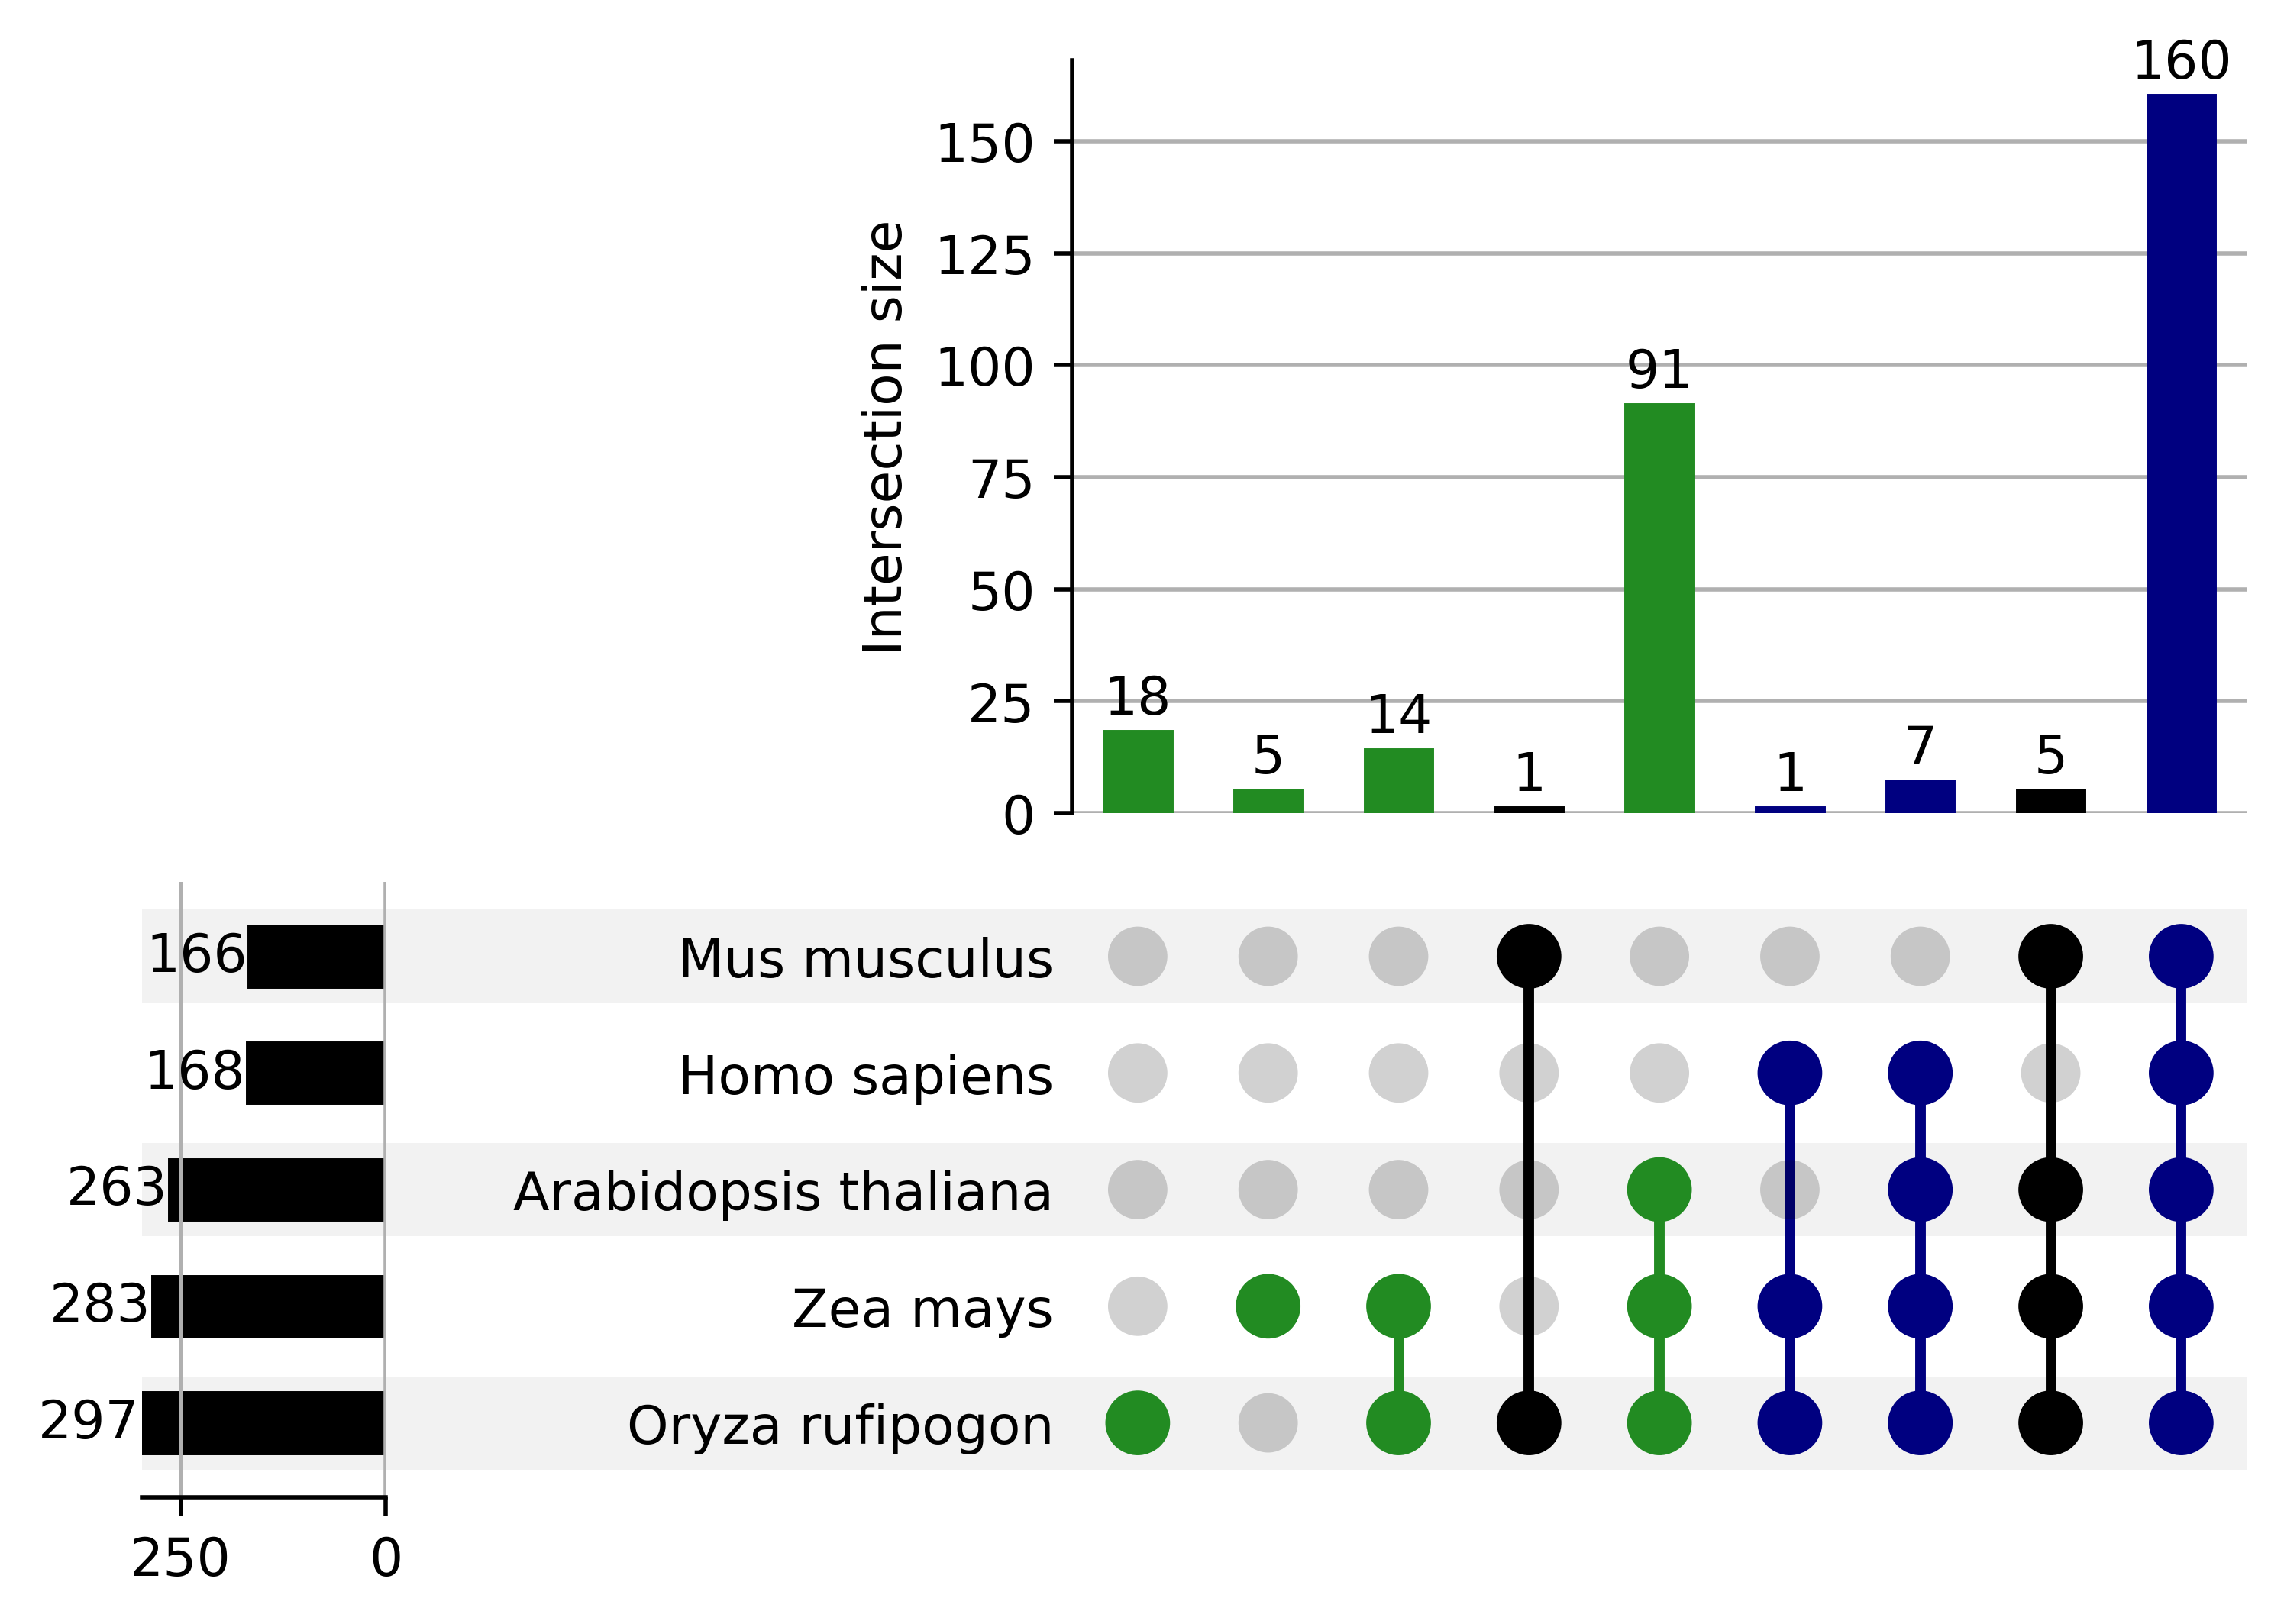

In [19]:
upset_plot = UpSet(
    upset_data,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(present="Homo sapiens", 
                         facecolor="navy"
                         )

upset_plot.style_subsets(absent=["Homo sapiens", "Mus musculus"], 
                         facecolor="forestgreen"
                         )

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

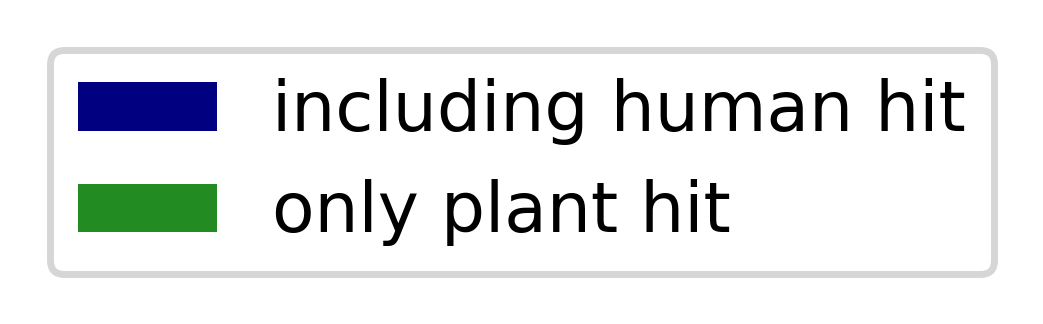

In [20]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label="including human hit"),
    Patch(facecolor='forestgreen', label='only plant hit')
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()
# fig_leg.savefig('legend.png', bbox_inches='tight')